In [1]:
import numpy as np
from scipy import sparse
from math import floor

import qiskit
from qiskit import Aer

import matplotlib.pyplot as plt
%matplotlib inline

import sys, os

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
from QubitRBM.optimize import *
import QubitRBM.exact_gates as eg
import QubitRBM.utils as utils
from QubitRBM.rbm2 import *

In [4]:
nv = 10
nh = 0 # to start off with, we can add more later

In [5]:
depth = 100
gates = [('RZZ', 2), ('RZ', 1), ('P', 1)]

In [6]:
logpsi = RBM(nv, nh)

In [7]:
psi0 = logpsi.get_state_vector(normalized=True)

In [8]:
qubits = qiskit.QuantumRegister(size=nv, name='q')
circ = qiskit.QuantumCircuit(qubits)

In [9]:
circ.h(qubits)

In [10]:
psi_scipy = psi0.copy()

In [11]:
%%time

for k in range(depth):
    
    i = np.random.randint(low=0, high=len(gates))
    gate, nqs = gates[i]
    
    qs = np.random.choice(np.arange(nv), size=nqs, replace=False)
    phi = np.random.uniform(low=-np.pi, high=np.pi)
    
    if gate=='RZ':
        logpsi.RZ(*qs, phi)
        psi_scipy = eg.RZ(phi, *qs, nv).dot(psi_scipy)
        circ.rz(phi, *qs)
    elif gate=='RZZ':
        logpsi.RZZ(*qs, phi)
        psi_scipy = eg.RZZ(phi, *qs, nv).dot(psi_scipy)
        circ.rzz(phi, *qs)
    elif gate=='P':
        logpsi.P(*qs, phi)
        psi_scipy = eg.P(phi, *qs, nv).dot(psi_scipy)
        circ.x(*qs)
        circ.rz(phi, *qs)

CPU times: user 907 ms, sys: 90.2 ms, total: 997 ms
Wall time: 1.01 s


In [12]:
logpsi.fold_imag_params()

In [13]:
psi = logpsi.get_state_vector(normalized=True)

In [14]:
# backend = Aer.get_backend('statevector_simulator')

In [15]:
# %%time
# job = qiskit.execute(circ, backend)
# phi = job.result().get_statevector(circ, decimals=30)

In [16]:
# utils.exact_fidelity(psi, phi)

In [17]:
utils.exact_fidelity(psi, psi_scipy)

0.9999999999999993

What to expect after the Hadamard transform:

In [18]:
circ.h(qubits)

In [19]:
backend = Aer.get_backend('statevector_simulator')

In [20]:
%%time
job = qiskit.execute(circ, backend)
result = job.result()
psi_exact = result.get_statevector(circ, decimals=50)

CPU times: user 172 ms, sys: 4.68 ms, total: 177 ms
Wall time: 177 ms


In [21]:
p_exact = np.abs(psi_exact)**2

In [22]:
p_exact.sum()

0.9999999999999996

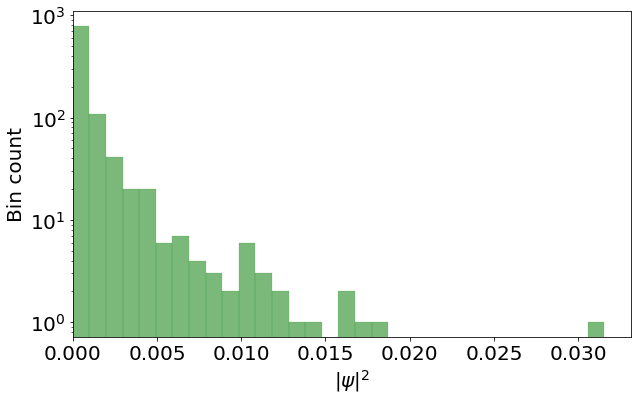

In [23]:
color = 'forestgreen'

fig, ax = plt.subplots(figsize=[10,6])

ax.set_yscale('log')
ax.hist(p_exact, bins='sqrt', lw=0.25, color=color, edgecolor=color, alpha=0.6)

ax.set_xlim(0)

ax.set_xlabel(r'$\vert \psi \vert ^2 $', fontsize=20)
ax.set_ylabel(r'Bin count', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

The SciPy version:

In [24]:
psi_scipy = eg.H(n=range(nv), n_qubits=nv).dot(psi_scipy)

In [25]:
p_scipy = np.abs(psi_scipy)**2

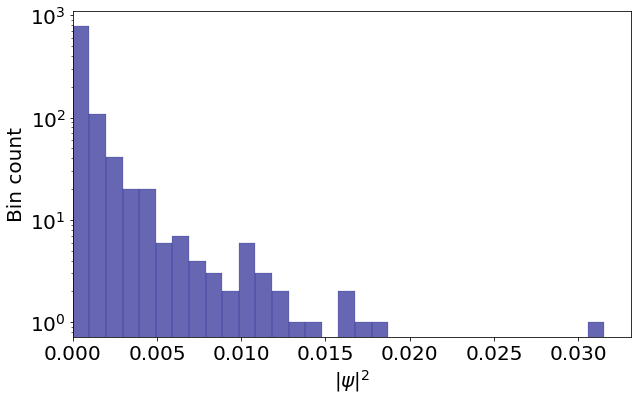

In [26]:
color = 'navy'

fig, ax = plt.subplots(figsize=[10,6])

ax.set_yscale('log')
ax.hist(p_scipy, bins='sqrt', lw=0.25, color=color, edgecolor=color, alpha=0.6)

ax.set_xlim(0)

ax.set_xlabel(r'$\vert \psi \vert ^2 $', fontsize=20)
ax.set_ylabel(r'Bin count', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

## The Hadamard transform

In [27]:
psi0 = logpsi.get_state_vector(normalized=True)
target_state = eg.H(n=range(logpsi.nv), n_qubits=logpsi.nv).dot(psi0)

In [ ]:
logpsi.nh/logpsi.nv

In [29]:
r = 4

In [30]:
if logpsi.nh/logpsi.nv < target_r:
    logpsi.add_hidden_units(target_r*logpsi.nv - logpsi.nh)

In [31]:
logpsi.nh/logpsi.nv

4.0

In [32]:
lr = 1e-1
lrf = 8e-2
# steps = 400
# lr_tau = steps/np.log(lr/lrf)
lr_tau = None
lr_min = lrf

In [33]:
tol = 1e-6

In [34]:
%%time

for n in range(nv):
    
    psi0 = logpsi.get_state_vector(normalized=True)
    phi = eg.H(n=n, n_qubits=logpsi.nv).dot(psi0)
    
    print('Qubit {} starting...'.format(n+1))
    
    while True:

        a, b, W, Fs = hadamard_optimization(logpsi, n, tol=tol, lr=lr, lr_tau=lr_tau, lr_min=lr_min,
                                           lookback=50, resample_phi=None, sigma=0.0, fidelity='mcmc',
                                           psi_mcmc_params=(500,50,1), phi_mcmc_params=(500,50,1),
                                           eps=1e-6, verbose=True)
        
        if Fs[-1] > 0.95:
            logpsi.set_params(a=a, b=b, W=W)
            logpsi.fold_imag_params()
            break
        else:
            print('||Repeating optimization, adding {} hidden units||'.format(logpsi.nv//2))
            logpsi.add_hidden_units(logpsi.nv//2)
    
    psi = logpsi.get_state_vector(normalized=True)
    F = utils.exact_fidelity(psi, phi)
    
    print('\nQubit {} done! Exact fidelity reached: {:05.4f}'.format(n+1, F))
    print('Total fidelity: {:07.6f}\n'.format(utils.exact_fidelity(psi, target_state)))

Qubit 1 starting...
Iteration  145 | Fidelity = 0.9981 | lr = 0.100

Qubit 1 done! Exact fidelity reached: 0.9931
Total fidelity: 0.000019

Qubit 2 starting...
Iteration  153 | Fidelity = 0.0159 | lr = 0.100
Iteration  309 | Fidelity = 0.3613 | lr = 0.100

Qubit 2 done! Exact fidelity reached: 0.9973
Total fidelity: 0.000016

Qubit 3 starting...
Iteration  153 | Fidelity = 0.9946 | lr = 0.100
Iteration  302 | Fidelity = 0.9981 | lr = 0.100
Iteration  433 | Fidelity = 0.9869 | lr = 0.100

Qubit 3 done! Exact fidelity reached: 0.9955
Total fidelity: 0.000083

Qubit 4 starting...
Iteration  136 | Fidelity = 0.9859 | lr = 0.100
Iteration  285 | Fidelity = 0.9853 | lr = 0.100
Iteration  426 | Fidelity = 0.9909 | lr = 0.100
Iteration  578 | Fidelity = 0.9952 | lr = 0.100
Iteration  722 | Fidelity = 0.9920 | lr = 0.100

Qubit 4 done! Exact fidelity reached: 0.9937
Total fidelity: 0.001020

Qubit 5 starting...
Iteration  144 | Fidelity = 0.9078 | lr = 0.100
||Repeating optimization...||
Iterat

In [44]:
logpsi.nh/logpsi.nv

6.5

Final state fidelity:

In [35]:
psi = logpsi.get_state_vector(normalized=True)

In [36]:
utils.exact_fidelity(psi, psi_scipy)

0.8535012663123901

In [37]:
p = np.abs(psi)**2

In [38]:
p.sum()

0.9999999999999954

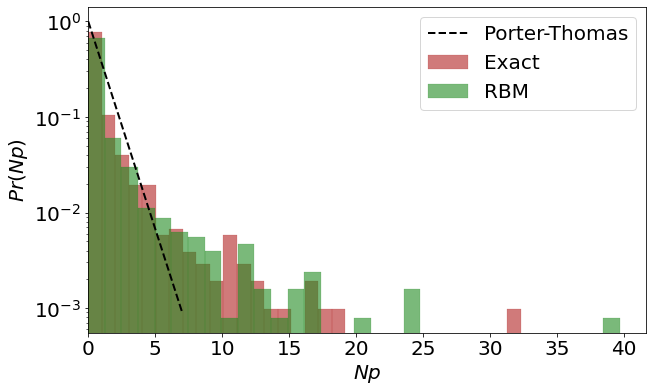

In [77]:
fig, ax = plt.subplots(figsize=[10,6])

ax.set_yscale('log')

N = 2**logpsi.nv

o = ax.hist(N*p_scipy, bins='sqrt', lw=0.25, density=True, color='firebrick', edgecolor='firebrick', alpha=0.6, label='Exact')
ax.hist(N*p, bins='sqrt', lw=0.25, density=True, color='forestgreen', edgecolor='forestgreen', alpha=0.6, label='RBM')

Nps = np.linspace(0, 7, 10)
ax.plot(Nps, np.exp(-Nps), ls='--', lw=2, c='k', label='Porter-Thomas')

ax.legend(frameon=True, fontsize=20)
ax.set_xlim(0)
ax.set_xlabel(r'$ N p $', fontsize=20)
ax.set_ylabel(r'$ Pr(Np) $', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plt.savefig('first_sim.pdf')